# Projet 10 - Détecter des faux billets

# Modélisation

## Régression logistique

In [13]:
# initialisation du modèle de régression logistique
model = LogisticRegression()

# entraînement du modèle sur l'ensemble d'entraînement
model.fit(X_train_imputed, y_train)

# prédiction des étiquettes sur l'ensemble de test
y_pred = model.predict(X_test_imputed)

# test de modification d'hyperparamètres. résultats toujours <= à l'accuracy actuelle
# model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)

# on évalue la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# affichage des résultats
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# confirmation par validation croisée (ou cross-validation)
cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Accuracy: 0.9888888888888889
Confusion Matrix:
[[157   4]
 [  1 288]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       161
        True       0.99      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Cross-Validation Scores: [0.99047619 0.98095238 0.98571429 0.9952381  0.9952381 ]
Mean CV Accuracy: 0.9895238095238096


Expliquation de l'imputation: cette technique permet de remplacer les NaN par des valeurs définies. Cependant, contrairement à la simple modifictation par la médiane, on remplace les NaN de la phase de validation après que les tests aient été effectués, ce qui permet de les adapter en conséquence et d'être plus proche du réel.

Explication des résultats:
- L'accuracy (ou précision) est de 98.9%, ce qui confirme la stabilité du test. Les modifications hyperparamétriques ne permettent pas de monter encore plus haut.
- La "Matrice de confustion" nous informe que 157 vrais billets et 288 faux ont été détectés comme tels. Seuls 4 vrais ont été étiquettés "faux négatif", et 1 faux est vu comme "faux positif".

Le <b>rapport de classification </b> confirme ce résultat.

Afin de s'assurer de la qualité du modèle, nous allons effectuer une analyse de l'homosédasticité des résidus (les erreurs).

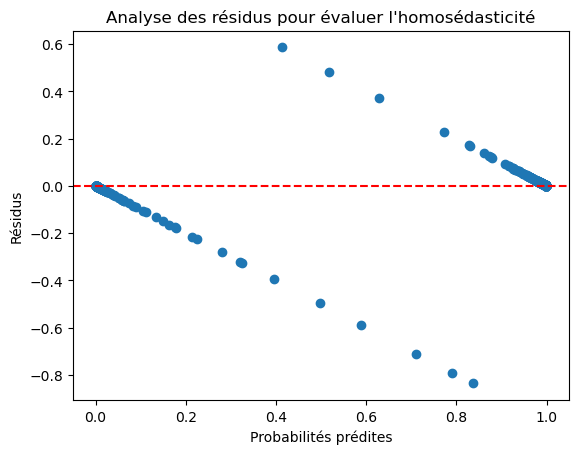

In [14]:
# Prédiction des probabilités des classes positives sur l'ensemble de test
y_prob = model.predict_proba(X_test_imputed)[:, 1]

# Calcul des résidus
residuals = y_test - y_prob

# Tracer les résidus par rapport aux probabilités prédites
plt.scatter(y_prob, residuals)
plt.xlabel('Probabilités prédites')
plt.ylabel('Résidus')
plt.title('Analyse des résidus pour évaluer l\'homosédasticité')
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à la hauteur zéro pour repérer les résidus
plt.show()


On peut tirer deux informations principales dans ce schéma:
- Le tracé rouge se situe à 0, ce qui confirme la capacité de prédiction du modèle MAIS
- Les deux "lignes de points" semblent indiquer une hétérosédastcicité des résidus (la dispersion des erreurs diminue au fur et à mesure), et le parallélisme de la seconde démontre une certaine régularité dans ces apparitions. Il semble qu'un aspect des données ne soit systématiquement pas pris en compte correctement.


Dans l'ensemble, les résultats sont très positifs, car le taux de précision semble indiquer que la conception d'un modèle binaire suffirait à évaluer la qualité des futurs billets. Seul point négatif: un "aspect oublié" dans l'analyse.
Évaluons le dataframe avec d'autres outils, afin de s'assurer que nous n'avons pas manqué une relation entre les variables ou une information particulière.

Plusieurs modèles complexes existent : réseau de neurones, RandomForest ou encore XGboost. Nous allons utiliser ce dernier pour creuser en profondeur, mais avant tout, vérifions si les données sont réellement normales, car l'erreur peut provenir de là.

## DecisionTree et RandomForest

In [ ]:
# Définissez les modèles et les hyperparamètres que vous souhaitez comparer
models_to_compare = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

# Définissez les hyperparamètres à rechercher pour chaque modèle
param_grid = {
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
}

# Comparez les modèles avec validation croisée
for model_name, model in models_to_compare.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_imputed, y_train)

    # Affichez les meilleurs hyperparamètres et la performance
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_}\n")

Nous cherchons le meilleur modèle :

    Nous comparons trois modèles : Régression Logistique, Arbre de Décision, et Forêt Aléatoire.
    Pour chaque modèle, nous essayons différentes configurations (hyperparamètres) pour trouver celle qui donne les meilleures prédictions.

Voici ce que chaque modèle fait :

    Régression Logistique : Il essaie de trouver une ligne qui sépare les données en deux catégories.
    Arbre de Décision : Il prend des décisions basées sur les caractéristiques des billets, construisant une sorte d'arbre de décision.
    Forêt Aléatoire : C'est comme un groupe d'arbres de décision, et ils votent ensemble pour décider de la catégorie d'un billet.

Ce que nous regardons :

    Pour chaque modèle, nous testons différentes façons de le configurer (paramètres).
    Nous utilisons la validation croisée pour évaluer à quel point chaque configuration est performante.
    Le modèle avec la meilleure configuration (paramètres) et la meilleure performance est celui que nous choisirons.

Objectif :

    Trouver le modèle qui peut prédire le mieux si un billet est vrai ou faux à partir de ses caractéristiques.

C'est comme si nous essayions différentes approches pour résoudre un problème, et nous choisissons celle qui donne les meilleurs résultats.


## Transformation des données non normées

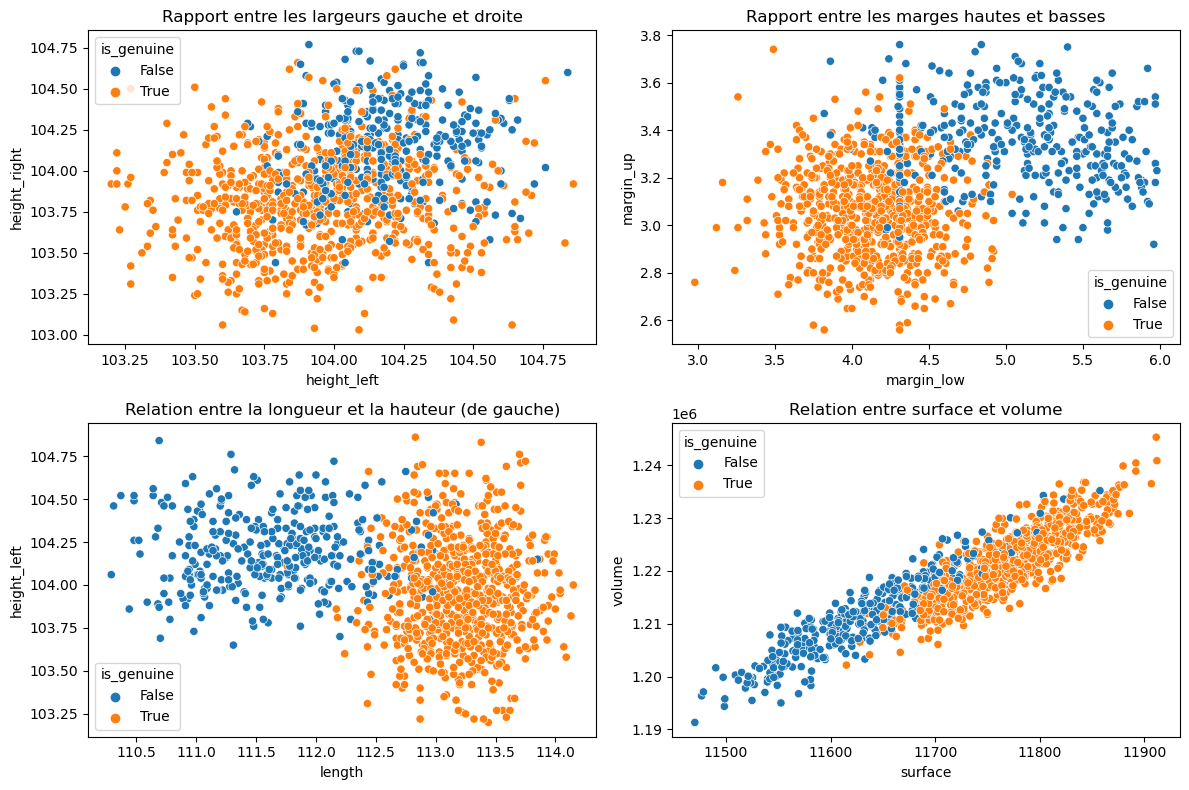

In [28]:
# Point 1 : Rapports entre les caractéristiques
données_imputées['height_ratio'] = données_imputées['height_left'] / données_imputées['height_right']
données_imputées['margin_ratio'] = données_imputées['margin_low'] / données_imputées['margin_up']

# Point 2 : Caractéristiques basées sur les dimensions
données_imputées['surface'] = données_imputées['length'] * données_imputées['height_left']
données_imputées['volume'] = données_imputées['length'] * données_imputées['height_left'] * données_imputées['height_right']

# Visualisation des résultats
plt.figure(figsize=(12, 8))

# Rapports entre les caractéristiques
plt.subplot(2, 2, 1)
sns.scatterplot(x='height_left', y='height_right', hue='is_genuine', data=données_imputées)
plt.title('Rapport entre les largeurs gauche et droite')

plt.subplot(2, 2, 2)
sns.scatterplot(x='margin_low', y='margin_up', hue='is_genuine', data=données_imputées)
plt.title('Rapport entre les marges hautes et basses')

# Caractéristiques basées sur les dimensions
plt.subplot(2, 2, 3)
sns.scatterplot(x='length', y='height_left', hue='is_genuine', data=données_imputées)
plt.title('Relation entre la longueur et la hauteur (de gauche)')

plt.subplot(2, 2, 4)
sns.scatterplot(x='surface', y='volume', hue='is_genuine', data=données_imputées)
plt.title('Relation entre surface et volume')

plt.tight_layout()
plt.show()

# Notes

Questions qui ont été posées à Lou lors de sa soutenance :

    Pourquoi traiter les valeurs manquantes avec une régression linéaire dans une colonne d'un data frame au lieu d'autre chose?
        Traiter les valeurs manquantes avec une régression linéaire peut être une approche car elle permet de prédire les valeurs manquantes en se basant sur la relation linéaire entre la variable avec des valeurs manquantes et les autres variables du dataset. Cependant, cette méthode n'est pas toujours la plus appropriée, et d'autres méthodes, telles que l'imputation par la médiane, la moyenne ou d'autres méthodes statistiques, peuvent également être utilisées en fonction du contexte.

    Quand vous avez testé plusieurs régressions multiples, c'était pour tester quel type d'hypothèse, avec les valeurs numériques du tableau des résultats?
        Tester plusieurs régressions multiples pourrait viser à évaluer l'influence de différentes variables explicatives sur la variable dépendante. Cela permet de tester des hypothèses sur la force et la direction des relations entre ces variables dans le modèle.

    Comment s'appelle le fait de prédire la variable dépendante avec la variable explicative?
        Cela s'appelle la prédiction ou l'estimation de la variable dépendante en fonction de la variable explicative.

    C'est quoi le R2 et à quoi ça sert?
        Le coefficient de détermination, souvent appelé R2, mesure la proportion de la variance de la variable dépendante qui est expliquée par le modèle. Un R2 de 1 indique que le modèle explique parfaitement la variance de la variable dépendante, tandis qu'un R2 de 0 indique qu'il n'explique rien. En général, un R2 plus élevé est souhaitable, mais il doit être interprété avec d'autres considérations.

    Pourquoi la régression logistique?
        La régression logistique est utilisée lorsque la variable dépendante est binaire (deux catégories). Contrairement à la régression linéaire qui est utilisée pour des variables continues, la régression logistique est conçue pour modéliser la probabilité d'appartenance à une catégorie donnée.

    Table de confusion, c'est quoi?
        La table de confusion est utilisée en apprentissage automatique pour évaluer la performance d'un modèle de classification. Elle compare les prédictions du modèle avec les valeurs réelles et divise les résultats en quatre catégories: vrais positifs (VP), vrais négatifs (VN), faux positifs (FP) et faux négatifs (FN). Elle est souvent utilisée pour calculer des métriques telles que la précision, le rappel et le score F1.

Faire une analyse levier

Faire la courbe de ROC à chaque algo

Faire le test de Variance Inflation Factor (colinéarité)

Faire un test de linéarité?

Faire apparaitre le R²

Dans les tests d'homosédasticité, comparer les billets selon is_genuine

Modifier l'imputation selon is_genuine et par régression (et non médiane)